In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
from functools import reduce
from scipy.stats import norm
import math

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('../data/APP_DATA.csv')
df.head()

,read_id,problem_id,user_id,score,contest_id,topic_id,current_labeling_state,response_submitted_at,problem_appeared_at,origin,origin_created_at,current_correct_answer,chosen_answer
0,12487219,811701,19769,0,964,151,gold_standard,2020-05-11 09:20:30.368000+00:00,2020-05-11 09:20:28.227000+00:00,ISIC_0032589.jpg,2020-05-01 22:54:11.396343+00:00,['nevus'],['melanoma']
1,12487220,818497,19769,0,964,151,gold_standard,2020-05-11 09:20:33.121000+00:00,2020-05-11 09:20:31.558000+00:00,ISIC_0025791.jpg,2020-05-02 00:19:43.094013+00:00,['melanoma'],['nevus']
2,12487221,818545,19769,100,964,151,gold_standard,2020-05-11 09:20:34.904000+00:00,2020-05-11 09:20:34.094000+00:00,ISIC_0025748.jpg,2020-05-02 00:20:24.839681+00:00,['melanoma'],['melanoma']
3,12487222,816711,19769,0,964,151,gold_standard,2020-05-11 09:20:39.525000+00:00,2020-05-11 09:20:38.106000+00:00,ISIC_0027572.jpg,2020-05-01 23:54:21.810276+00:00,['nevus'],['melanoma']
4,12487223,812299,19769,100,964,151,gold_standard,2020-05-11 09:20:41.446000+00:00,2020-05-11 09:20:40.661000+00:00,ISIC_0031977.jpg,2020-05-01 22:58:16.517135+00:00,['melanoma'],['melanoma']


In [4]:
len(df), df.user_id.nunique()

(758139, 1173)

In [5]:
df.groupby('user_id').count().describe()

,read_id,problem_id,score,contest_id,topic_id,current_labeling_state,response_submitted_at,problem_appeared_at,origin,origin_created_at,current_correct_answer,chosen_answer
count,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000
mean,646.324808,646.324808,646.324808,646.324808,646.324808,646.324808,646.324808,646.324808,646.324808,646.324808,646.324808,646.324808
std,2009.998212,2009.998212,2009.998212,2009.998212,2009.998212,2009.998212,2009.998212,2009.998212,2009.998212,2009.998212,2009.998212,2009.998212
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
50%,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
75%,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000
max,33786.000000,33786.000000,33786.000000,33786.000000,33786.000000,33786.000000,33786.000000,33786.000000,33786.000000,33786.000000,33786.000000,33786.000000


In [6]:
100* 324050 / 758139

42.74282156702135

In [7]:
df.current_correct_answer.value_counts()

['nevus']       434089
['melanoma']    324050
Name: current_correct_answer, dtype: int64

# Preliminary preprocessing

In [8]:
# Drop unused columns, rename labels and columns
df_prepro = df.drop(['read_id', 'topic_id'], axis=1)
df_prepro['chosen_answer'] = df_prepro.chosen_answer.replace({"['nevus']": 'nevus', "['melanoma']": 'melanoma'})
df_prepro['current_correct_answer'] = df_prepro.current_correct_answer.replace({"['nevus']": 'nevus', "['melanoma']": 'melanoma'})
df_prepro = df_prepro.rename(columns={'user_id': 'participant_id','chosen_answer': 'answer', 'origin': 'image', 
                                      'origin_created_at':'image_created_at', 'current_correct_answer':'label',
                                     'problem_id': 'image_id'})
df_prepro['image_name'] = df_prepro.image.str[:-4]
df_prepro['score'] = (df_prepro.answer == df_prepro.label).astype(int)
df_prepro['target'] = (df_prepro.label == 'melanoma').astype(int)

# Convert columns to right type
cat_cols = ['contest_id', 'current_labeling_state', 'label', 'answer', 'image']
for col in cat_cols:
    df_prepro[col] = pd.Categorical(df_prepro[col])

date_cols = ['response_submitted_at', 'problem_appeared_at', 'image_created_at']
for col in date_cols:
    df_prepro[col] = pd.to_datetime(df_prepro[col])

prev_len = len(df_prepro)
df_prepro = df_prepro.query("current_labeling_state == 'gold_standard'")
print(f"Dropped {prev_len - len(df_prepro)} rows")

df_prepro['RT'] = (df_prepro['response_submitted_at'] - df_prepro['problem_appeared_at']) / np.timedelta64(1, 's')
prev_len = len(df_prepro)
df_prepro = df_prepro.query("RT > 0")
print(f"Dropped {prev_len - len(df_prepro)} rows")

q1 = np.percentile(df_prepro.RT, 25)
q3 = np.percentile(df_prepro.RT, 75)
iqr = q3 - q1
prev_len = len(df_prepro)
df_prepro = df_prepro.query('(RT >= @q1 - 1.5*@iqr) & (RT <= @q3 + 1.5*@iqr)')

#RT_mean = df_prepro.RT.mean()
#RT_std = df_prepro.RT.std()
#df_prepro = df_prepro.query('(RT >= @RT_mean - 3*@RT_std) & (RT <= @RT_mean + 3*@RT_std)')

print(f"Dropped {prev_len - len(df_prepro)} rows")
#df_prepro.RT.plot(kind='hist', bins=50)

Dropped 1055 rows
Dropped 1 rows
Dropped 76051 rows


In [9]:
len(df_prepro)

681032

In [10]:
q1, q3, iqr, q1-1.5*iqr, q3+1.5*iqr

(0.755, 1.331, 0.576, -0.10899999999999987, 2.195)

Text(0.5, 0, 'Response time in sec')

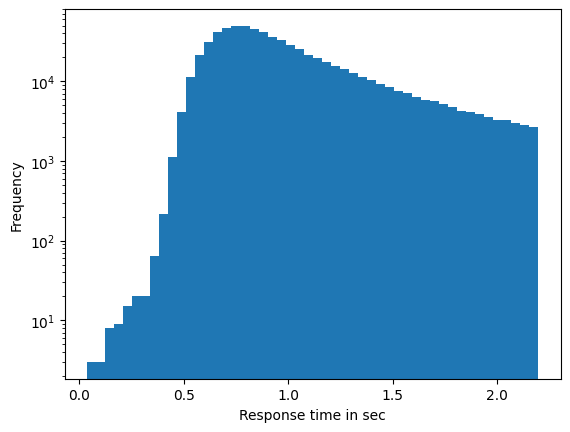

In [11]:
df_prepro.RT.plot(kind='hist', bins=50, log=True)
plt.xlabel('Response time in sec')

In [12]:
df_prepro.RT.describe()

count    681032.000000
mean          0.998216
std           0.358597
min           0.038000
25%           0.738999
50%           0.897000
75%           1.166000
max           2.195000
Name: RT, dtype: float64

### Merge participant and image data

In [13]:
n_clusters = 100
#_save
images = pd.read_csv(f'data/image_clusters_{n_clusters}_save.csv')[['image_name', 'cluster', 'x', 'y', 'benign_malignant']]
assert images.image_name.duplicated().sum() == 0

In [31]:
images.query('x > 60').cluster.unique()

array([28, 95, 67, 66, 80, 43, 23, 44, 61, 52, 82, 55])

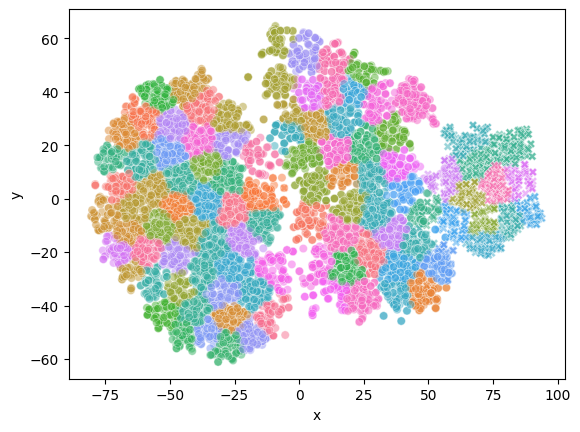

In [34]:
sns.scatterplot(images, x='x', y='y', hue='cluster', style='benign_malignant', alpha=0.5,
               palette=sns.color_palette("husl", n_clusters))
plt.legend([],[], frameon=False)
plt.show()

In [50]:
right_clusters = [28, 95, 67, 66, 80, 43, 23, 44, 61, 52, 82, 55]
left_clusters = images.query('cluster not in @right_clusters')
left_clusters = image_filtered.query('x + 0.3*y < -10').cluster.unique()
 = images.query('(cluster not in @right_clusters) & (cluster not in @left_clusters)').cluster.unique()

/var/folders/8s/g3q9xv_x6v98ym_3vh55_nsh0000gn/T/ipykernel_37460/4166740023.py:1: UserWarning: The palette list has more values (100) than needed (39), which may not be intended.
  sns.scatterplot(middle_clusters, x='x', y='y', hue='cluster', style='benign_malignant', alpha=0.5,


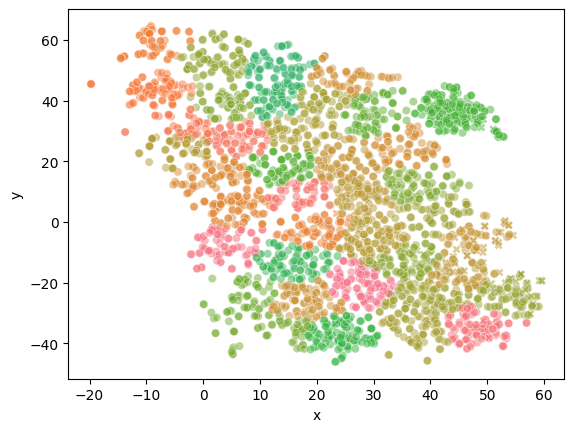

In [51]:

sns.scatterplot(middle_clusters, x='x', y='y', hue='cluster', style='benign_malignant', alpha=0.5,
               palette=sns.color_palette("husl", n_clusters))
plt.legend([],[], frameon=False)
plt.show()

In [15]:
all_trials = df_prepro.merge(images, on='image_name')
all_trials['accuracy'] = (all_trials.label == all_trials.answer).astype(int)
assert len(all_trials) == len(df_prepro)

In [109]:
all_trials.to_csv('data/trials_all_participants.csv', index=False)

### Sample participants' trials

In [16]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
participant_trials_sample_ratio = 0.25

In [17]:
trials_sample = all_trials.groupby('participant_id').sample(frac=participant_trials_sample_ratio,
                                                            random_state=SEED)
trials_exp = all_trials.drop(trials_sample.index)
assert len(trials_sample) + len(trials_exp) == len(all_trials)
print(len(trials_sample), len(trials_exp))

170257 510775


### Filter participants with a minimum of trials in each cluster

In [18]:
min_trials_per_cluster = 2

In [19]:
# Filter participants with not enough trials in each cluters
cluster_trial_mask = trials_exp.groupby(['participant_id', 'cluster']).count()\
                                .groupby(level=0).min()[['image_id']] >= min_trials_per_cluster
cluster_trial_mask.columns = ['enough_trials']

# Filter participants with missing clusters
all_cluster_mask = trials_exp.groupby('participant_id')[['cluster']].nunique() == n_clusters
all_cluster_mask.columns = ['all_clusters']

trials_exp_filtered = trials_exp.merge(cluster_trial_mask.query('enough_trials'), 
                                        left_on='participant_id', right_index=True)\
                        .merge(all_cluster_mask.query('all_clusters'), 
                            left_on='participant_id', right_index=True)

# Create a subset of sample with only participants included in the experiment 
trials_sample_filtered = trials_sample.query('participant_id in @trials_exp_filtered.participant_id.unique()')
print("Nb of remaining participants:", trials_exp_filtered.participant_id.nunique())
print("Remaining experiment trials:", len(trials_exp_filtered))
print("Remaining sample trials:", len(trials_sample_filtered))

Nb of remaining participants: 81
Remaining experiment trials: 333600
Remaining sample trials: 111205


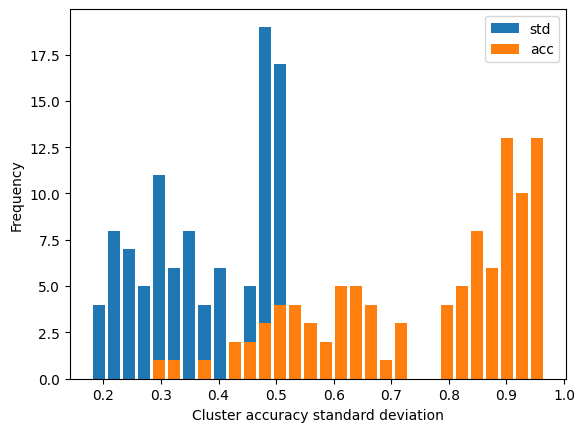

In [20]:
# Use sample from all participants to estimate cluster standard deviation
cluster_accuracy = trials_sample.groupby('cluster')[['accuracy']].agg(std=('accuracy','std'),
                                                                     acc=('accuracy','mean')).sort_values('std')

# Use sample to estimate participants' performance
sample_performance = trials_sample_filtered.groupby('participant_id').agg(mean_accuracy=('accuracy','mean'))
participant_ordering = sample_performance.sort_values('mean_accuracy')

cluster_accuracy.plot(kind='hist', bins=30, rwidth=0.8)
plt.xlabel('Cluster accuracy standard deviation')
plt.show()

In [21]:
metrics = trials_sample.groupby('cluster')[['accuracy']].agg(acc=('accuracy','mean'), 
                                                   std=('accuracy','std')).query('std > 0.4')

#metrics.sort_values(by='acc')

In [22]:
participant_ordering.describe()

,mean_accuracy
count,81.000000
mean,0.782972
std,0.048560
min,0.677130
25%,0.755287
50%,0.784677
75%,0.806266
max,0.923797


In [23]:
cluster_accuracy

,std,acc
cluster,,
12,0.178581,0.967054
98,0.182377,0.965589
18,0.195283,0.960325
16,0.197949,0.959217
44,0.209668,0.953920
...,...,...
27,0.499978,0.514956
79,0.500041,0.488339
84,0.500061,0.512299


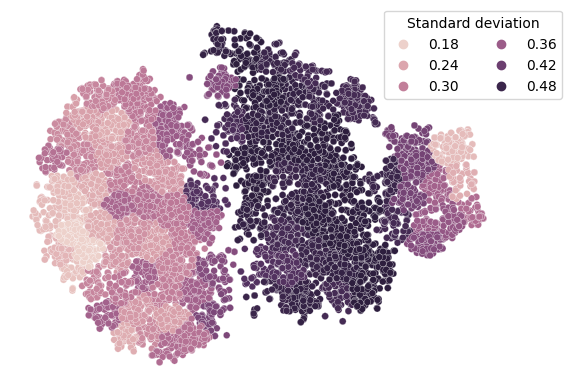

In [24]:
cluster_std = images.merge(cluster_accuracy.reset_index())
cluster_std['std'] = cluster_std['std'].round(2)
sns.scatterplot(cluster_std, x='x', y='y', hue='std', alpha=1, s=24, linewidth=0.2)#rocket_r #mako_r#magma_r #OrRd #PuRd
plt.axis('off')
plt.legend(title='Standard deviation', ncol=2, bbox_to_anchor=(0.74, 0.74))
#plt.savefig('standard_deviation.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
cluster_std_sub = cluster_std.query('cluster not in [28, 95, 67, 66, 80, 43, 23, 44, 61, 52, 82, 55]')

In [38]:
pearsonr(cluster_std_sub.x, cluster_std_sub['std'])

PearsonRResult(statistic=0.9083268524478126, pvalue=0.0)

In [39]:
pearsonr(cluster_std_sub.x, cluster_std_sub['acc'])

PearsonRResult(statistic=-0.8351996612551114, pvalue=0.0)

In [55]:
middle_clusters

,image_name,cluster,x,y,benign_malignant
7,ISIC_0024314,92,20.034170,-41.124836,benign
10,ISIC_0024317,83,6.561492,39.296590,benign
11,ISIC_0024319,25,18.192125,-2.938969,benign
19,ISIC_0024328,25,19.395975,-4.776699,benign
24,ISIC_0024340,22,-7.353755,47.625380,benign
...,...,...,...,...,...
7810,ISIC_0034311,25,22.260780,-8.095316,benign
7811,ISIC_0034312,36,13.059208,-29.215551,benign
7813,ISIC_0034314,88,27.356876,31.819136,benign
7816,ISIC_0034319,68,44.939533,2.561900,benign


In [57]:
ttest_ind(cluster_std.query('cluster in @left_clusters')['acc'], 
          cluster_std.query('cluster in @right_clusters')['acc'])

Ttest_indResult(statistic=38.652050519429345, pvalue=1.3024866034226814e-284)

In [ ]:
image_filtered_clusters

NameError: name 'cluster_std' is not defined

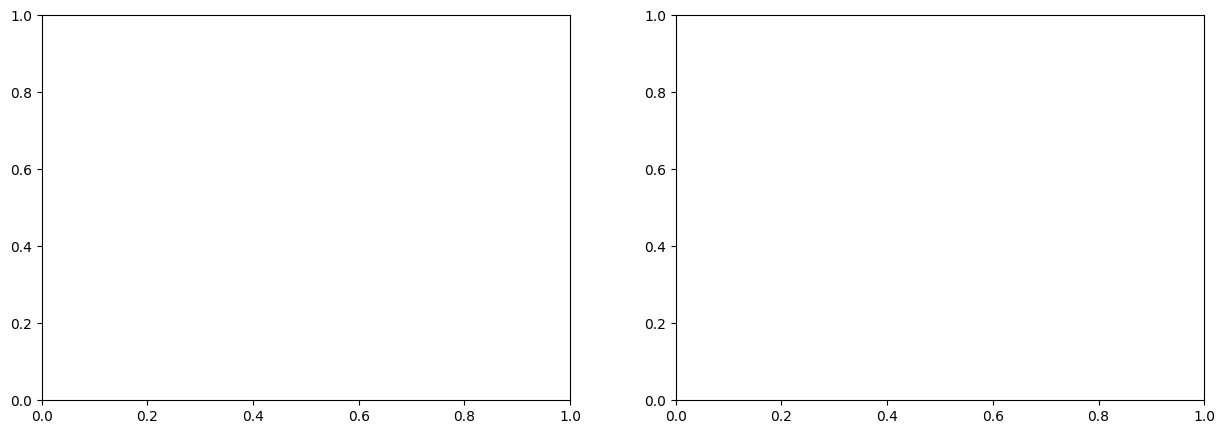

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
cluster_metrics = images.merge(cluster_accuracy.reset_index())
cluster_metrics['acc'] = cluster_metrics['acc'].round(2)
cluster_std['std'] = cluster_std['std'].round(2)

sns.scatterplot(cluster_metrics, x='x', y='y', hue='acc', alpha=1, s=24, linewidth=0.2, ax=axes[0])#rocket_r #mako_r#magma_r #OrRd #PuRd
axes[0].legend(title='Diagnostic accuracy', ncol=2, bbox_to_anchor=(0.74, 0.74),
              prop={'size': 13}, title_fontsize=14, markerscale=1, columnspacing=0.2, handletextpad=0.1)
axes[0].axis('off')
sns.scatterplot(cluster_metrics, x='x', y='y', hue='std', alpha=1, s=24, linewidth=0.2, ax=axes[1])#rocket_r #mako_r#magma_r #OrRd #PuRd
axes[1].legend(title='Standard deviation', ncol=2, bbox_to_anchor=(0.74, 0.74),
              prop={'size': 13}, title_fontsize=14, markerscale=1, columnspacing=0.2, handletextpad=0.1)
axes[1].axis('off')
plt.subplots_adjust(wspace=0.1)
plt.savefig('cluster_acc_std.svg', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
trials_exp_filtered.to_csv('data/trials_exp.csv', index=False)
cluster_accuracy.to_csv('data/cluster_accuracy.csv', index=True)
participant_ordering.to_csv('data/participant_ordering.csv', index=True)

## Reaction time consistency

In [25]:
from scipy.stats import pearsonr, ttest_ind

In [54]:
a, b = trials_exp_filtered.groupby('participant_id').mean(numeric_only=True)[['RT', 'accuracy']].values.T

In [55]:
half_idx = len(participant_ordering) // 2
low_group_ids, high_group_ids = participant_ordering.index[:half_idx], participant_ordering.index[-half_idx:]

In [58]:
rt_low = trials_exp_filtered.query('participant_id in @low_group_ids').groupby('participant_id').mean(numeric_only=True)['RT'].values
rt_high = trials_exp_filtered.query('participant_id in @high_group_ids').groupby('participant_id').mean(numeric_only=True)['RT'].values

In [59]:
ttest_ind(rt_low, rt_high)

Ttest_indResult(statistic=1.9606074521266657, pvalue=0.05349510346734039)

In [40]:
pearsonr(a, b)

PearsonRResult(statistic=-0.18185772129610403, pvalue=3.964473723624804e-10)

## Test-retest reliablility

In [ ]:
half1

[]

In [162]:
scores

array([1, 1])

In [167]:
np.nan is np.nan

True

In [173]:
import math

In [194]:
high_corrs = corrs
high_perm = perm_vals

In [192]:
low_corrs = corrs
low_perm = perm_vals

In [196]:
np.mean(np.array(high_corrs) - np.array(low_corrs) < np.array(high_perms) - np.array(low_perms))

ValueError: operands could not be broadcast together with shapes (39,) (36,) 

In [ ]:
np.mean(perm_df.within.high - perm_df.within.low < perm_df.within_perm.high - perm_df.within_perm.low)

In [193]:
corrs = []
perm_vals = []
for pid in tqdm(high_group_ids):#trials_exp_filtered.participant_id.unique()):
    p_trials = trials_exp_filtered.query('participant_id == @pid')
    mask = p_trials.groupby('image_id').count()['score'] >=2
    duplicate_diagnoses = mask.index[mask].tolist()
    if len(duplicate_diagnoses):
        half1, half2 = [], []
        for img_id in duplicate_diagnoses:
            scores = p_trials.query('image_id == @img_id').score.values
            if len(scores) % 2 == 1:
                scores = scores[:-1]
            half1.append(scores[:len(scores)//2])
            half2.append(scores[len(scores)//2:])
        half1, half2 = np.concatenate(half1), np.concatenate(half2)
        coef = np.corrcoef(half1,half2)[0][1]
        if not math.isnan(coef):
            corrs.append(coef)
            np.random.shuffle(half1)
            np.random.shuffle(half2)
            perm_vals.append(np.corrcoef(half1, half2)[0][1])

 90%|███████████████████████████████████████████████▋     | 36/40 [01:15<00:12,  3.24s/it]/Users/julien/Documents/Perception/venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/julien/Documents/Perception/venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|█████████████████████████████████████████████████████| 40/40 [01:18<00:00,  1.97s/it]


In [190]:
ttest_ind(high_corrs, corrs)

Ttest_indResult(statistic=2.0177682397079497, pvalue=0.04729155269711832)

In [185]:
np.mean(corrs), np.percentile(perm_vals, 97.5)

(0.43074530062902777, 0.11902453329983717)

In [143]:
p_trials.query('image_id in @duplicate_diagnoses').sort_values(['image_id', 'response_submitted_at'])

,image_id,participant_id,score,contest_id,current_labeling_state,response_submitted_at,problem_appeared_at,image,image_created_at,label,...,image_name,target,RT,cluster,x,y,benign_malignant,accuracy,enough_trials,all_clusters
114339,809966,19769,1,964,gold_standard,2020-05-11 09:49:14.122000+00:00,2020-05-11 09:49:12.696000+00:00,ISIC_0034317.jpg,2020-05-01 22:44:37.255697+00:00,melanoma,...,ISIC_0034317,1,1.426000,80,57.922620,3.233007,malignant,1,True,True
114366,809966,19769,1,979,gold_standard,2020-05-17 10:11:54.719000+00:00,2020-05-17 10:11:53.667000+00:00,ISIC_0034317.jpg,2020-05-01 22:44:37.255697+00:00,melanoma,...,ISIC_0034317,1,1.052000,80,57.922620,3.233007,malignant,1,True,True
114470,809966,19769,1,1444,gold_standard,2020-08-22 10:37:45.798000+00:00,2020-08-22 10:37:45.016000+00:00,ISIC_0034317.jpg,2020-05-01 22:44:37.255697+00:00,melanoma,...,ISIC_0034317,1,0.782000,80,57.922620,3.233007,malignant,1,True,True
101701,809969,19769,1,964,gold_standard,2020-05-11 09:46:40.051000+00:00,2020-05-11 09:46:39.072000+00:00,ISIC_0034313.jpg,2020-05-01 22:44:38.261694+00:00,melanoma,...,ISIC_0034313,1,0.979000,44,77.234695,22.757181,malignant,1,True,True
101733,809969,19769,1,979,gold_standard,2020-05-18 12:25:37.124000+00:00,2020-05-18 12:25:36.397000+00:00,ISIC_0034313.jpg,2020-05-01 22:44:38.261694+00:00,melanoma,...,ISIC_0034313,1,0.727000,44,77.234695,22.757181,malignant,1,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388662,819978,19769,0,1333,gold_standard,2020-08-08 09:05:50.052000+00:00,2020-08-08 09:05:49.145999+00:00,ISIC_0024313.jpg,2020-05-02 00:41:06.795571+00:00,melanoma,...,ISIC_0024313,1,0.906001,67,57.246872,-1.949731,malignant,0,True,True
388685,819978,19769,1,1444,gold_standard,2020-08-22 10:33:50.392999+00:00,2020-08-22 10:33:49.773000+00:00,ISIC_0024313.jpg,2020-05-02 00:41:06.795571+00:00,melanoma,...,ISIC_0024313,1,0.619999,67,57.246872,-1.949731,malignant,1,True,True
388820,819978,19769,1,2424,gold_standard,2021-01-04 02:43:30.523000+00:00,2021-01-04 02:43:28.872999+00:00,ISIC_0024313.jpg,2020-05-02 00:41:06.795571+00:00,melanoma,...,ISIC_0024313,1,1.650001,67,57.246872,-1.949731,malignant,1,True,True
269185,819981,19769,1,1333,gold_standard,2020-08-09 03:48:14.029000+00:00,2020-08-09 03:48:12.017000+00:00,ISIC_0024315.jpg,2020-05-02 00:41:09.282067+00:00,melanoma,...,ISIC_0024315,1,2.012000,95,75.475130,1.613232,malignant,1,True,True


In [120]:
p_trials.query('image_id in @duplicate_diagnoses').groupby('image_id').count().score.unique()

array([ 8,  6,  7,  9, 10])

In [144]:
corrs = []
half1 = []
half2 = []
for img_id in duplicate_diagnoses:
    scores = p_trials.query('image_id == @img_id').score.values
    if len(scores) % 2 == 1:
        scores = scores[:-1]
        
    #print(scores[:len(scores)//2], scores[len(scores)//2:])
    half1.append(scores[:len(scores)//2])
    half2.append(scores[len(scores)//2:])
half1 = np.concatenate(half1)
half2 = np.concatenate(half2)

In [146]:
np.corrcoef(np.concatenate(half1), np.concatenate(half2))

array([[1.        , 0.55255519],
       [0.55255519, 1.        ]])

In [137]:
pearsonr([0.001,0.001], [0.001,1])

PearsonRResult(statistic=nan, pvalue=nan)

In [133]:
np.corrcoef()

array([[1., 1.],
       [1., 1.]])

In [116]:
scores[:len(scores)//2], scores[len(scores)//2:]

(array([1, 1]), array([0, 1]))

In [107]:
corrs

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -0.4999999999999999,
 nan,
 nan,
 nan,
 -0.4999999999999999,
 nan,
 0.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.5,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.9999999999999999,
 nan,
 -0.4999999999999999,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 

In [103]:
scores[:len(scores)//2]

array([1])

## Performance groups

In [81]:
len(low_group_ids), len(high_group_ids)

(40, 40)

In [58]:
half_idx = len(participant_ordering) // 2
low_group_ids, high_group_ids = participant_ordering.index[:half_idx], participant_ordering.index[-half_idx:]

In [76]:
low_accs = trials_exp_filtered.query('participant_id in @low_group_ids').groupby('cluster')['accuracy'].mean().values
high_accs = trials_exp_filtered.query('participant_id in @high_group_ids').groupby('cluster')['accuracy'].mean().values

<Axes: ylabel='Frequency'>

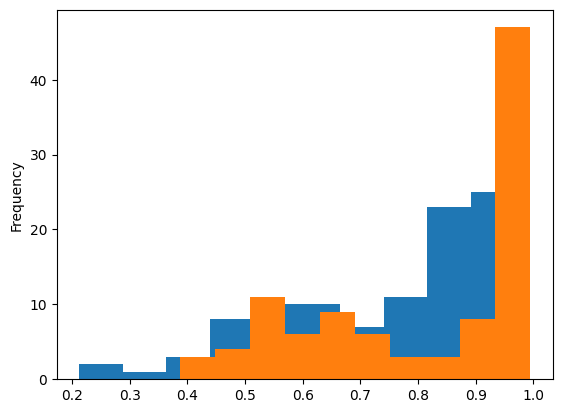

In [80]:
trials_exp_filtered.query('participant_id in @low_group_ids').groupby('cluster')['accuracy'].mean().plot(kind='hist')
trials_exp_filtered.query('participant_id in @high_group_ids').groupby('cluster')['accuracy'].mean().plot(kind='hist')

In [78]:
ttest_ind(low_accs, high_accs)

Ttest_indResult(statistic=-2.588227611537787, pvalue=0.010362321011670667)

In [84]:
trials_exp_filtered.query('participant_id in @high_group_ids').groupby('cluster')[['accuracy']].mean().mean()

accuracy    0.806192
dtype: float64